In [202]:
import random
import matplotlib.pyplot as plt
import numpy as np


In [203]:
class Bandit:
    def __init__(self, arm_num = 10):
        self.true_values = [random.gauss(0, 1) for _ in range(arm_num)]
        self.arm_num = arm_num

    def __call__(self, index):
        return self.true_values[index] + random.gauss(0, 1)
    
    def best_arm(self):
        max_value = max(self.true_values)
        best_arms = [i for i, v in enumerate(self.true_values) if v == max_value]
        best_arm = random.choice(best_arms)
        return best_arm

    def true_value(self, index):
        return self.true_values[index]

    def regret(self, chosen_arm):
        best_value = max(self.true_values)
        chosen_value = self.true_values[chosen_arm]
        return best_value - chosen_arm

In [204]:
class Agent:
    def __init__(self, arms_num = 10):
        self.arms_num = arms_num
        self.values = [0] * arms_num
        self.tries = [0] * arms_num
        self.award = 0
        self.history = {
            'chosen_arms': [],
            'rewards': [],
            'regrets': [],
            'values_history': [[] for _ in range(arms_num)]
        }

    def play(self, bandit, eps = 0.1):
        if random.random() < eps:
            bandit_index = random.randint(0, self.arms_num - 1)
        else:
            max_value = max(self.values)
            best_arms = [i for i, v in enumerate(self.values) if v == max_value]
            bandit_index = random.choice(best_arms)
        
        reward = bandit(bandit_index)
        regret = bandit.regret(bandit_index)

        self.award += reward
        self.tries[bandit_index] += 1
        self.values[bandit_index] += (reward - self.values[bandit_index])/self.tries[bandit_index]

        self.history['chosen_arms'].append(bandit_index)
        self.history['rewards'].append(reward)
        self.history['regrets'].append(regret)
        for i in range(self.arms_num):
            self.history['values_history'][i].append(self.values[i])

        return bandit_index, reward, regret

In [209]:
def plot_results(agent, bandit, n_steps):
    plt.figure(figsize=(15, 10))
    
    # 1. Распределение выборов рук
    plt.subplot(2, 3, 1)
    plt.bar(range(10), agent.tries)
    plt.axvline(x=bandit.best_arm(), color='red', linestyle='--', label='Лучшая рука')
    plt.title('Распределение выборов рук')
    plt.xlabel('Рука')
    plt.ylabel('Количество выборов')
    plt.legend()
    
    # 2. Кумулятивная награда
    plt.subplot(2, 3, 2)
    cumulative_rewards = np.cumsum(agent.history['rewards'])
    plt.plot(cumulative_rewards)
    plt.title('Кумулятивная награда')
    plt.xlabel('Шаги')
    plt.ylabel('Награда')
    
    # 3. Кумулятивное сожаление
    plt.subplot(2, 3, 3)
    cumulative_regret = np.cumsum(agent.history['regrets'])
    plt.plot(cumulative_regret, color='red')
    plt.title('Кумулятивное сожаление')
    plt.xlabel('Шаги')
    plt.ylabel('Сожаление')
    
    # 4. Эволюция оценок (первые 1000 шагов)
    plt.subplot(2, 3, 4)
    steps_to_show = min(1000, n_steps)
    for i in range(10):
        color = 'red' if i == bandit.best_arm() else 'blue'
        plt.plot(agent.history['values_history'][i][:steps_to_show], 
                color=color, alpha=0.7, label=f'Рука {i}' if i < 3 else "")
    
    # Добавляем истинные значения горизонтальными линиями
    for i in range(10):
        color = 'darkred' if i == bandit.best_arm() else 'darkblue'
        plt.axhline(y=bandit.true_values[i], color=color, linestyle='--', alpha=0.5)
    
    plt.title('Эволюция оценок (первые {} шагов)'.format(steps_to_show))
    plt.xlabel('Шаги')
    plt.ylabel('Оценка значения')
    if steps_to_show < 1000:  # Чтобы легенда не занимала много места
        plt.legend()
    
    # 5. Процент оптимальных действий
    plt.subplot(2, 3, 5)
    best_arm = bandit.best_arm()
    optimal_choices = [1 if arm == best_arm else 0 for arm in agent.history['chosen_arms']]
    window = 100
    moving_avg = np.convolve(optimal_choices, np.ones(window)/window, mode='valid')
    plt.plot(moving_avg)
    plt.title('Процент оптимальных действий (скользящее среднее)')
    plt.xlabel('Шаги')
    plt.ylabel('% оптимальных выборов')
    
    # 6. Сравнение истинных и оцененных значений
    plt.subplot(2, 3, 6)
    x_pos = np.arange(10)
    plt.bar(x_pos - 0.2, bandit.true_values, 0.4, label='Истинные', alpha=0.7)
    plt.bar(x_pos + 0.2, agent.values, 0.4, label='Оцененные', alpha=0.7)
    plt.title('Сравнение истинных и оцененных значений')
    plt.xlabel('Рука')
    plt.ylabel('Значение')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


# Сравнение разных значений epsilon
def compare_epsilons(n_steps=5000):
    epsilons = [0.01, 0.1, 0.3]
    colors = ['blue', 'green', 'red']
    
    plt.figure(figsize=(15, 5))
    
    for eps, color in zip(epsilons, colors):
        bandit = Bandit()
        agent = Agent()
        
        regrets_per_run = []
        for step in range(n_steps):
            _, _, regret = agent.play(bandit, eps)
            regrets_per_run.append(regret)
        
        cumulative_regret = np.cumsum(regrets_per_run)
        plt.plot(cumulative_regret, color=color, label=f'ε={eps}', alpha=0.8)
    
    plt.title('Сравнение кумулятивного сожаления для разных ε')
    plt.xlabel('Шаги')
    plt.ylabel('Кумулятивное сожаление')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [210]:
def run_experiment(steps_num = 1000, eps = 0.1):
    bandit = Bandit()
    agent = Agent()
     
    print("Истинные значения рук:")
    for i, value in enumerate(bandit.true_values):
        print(f"Рука {i}: {value:.3f}")

    best_arm = bandit.best_arm()
    print(f"Лучшая рука: {best_arm} (значение: {bandit.true_values[best_arm]:.3f})")
    
    for i in range(steps_num):
        agent.play(bandit, 0.1)
    print("\n=== РЕЗУЛЬТАТЫ ===")
    print("Количество выборов каждой руки:", agent.tries)
    print("Оценки значений:", [round(v, 3) for v in agent.values])
    print("Общая награда:", round(agent.award, 2))
    
    # Кумулятивное сожаление - важная метрика!
    cumulative_regret = np.cumsum(agent.history['regrets'])
    print(f"Финальное кумулятивное сожаление: {cumulative_regret[-1]:.2f}")
    
    # Визуализация
    plot_results(agent, bandit, steps_num)
    
    return agent, bandit

Истинные значения рук:
Рука 0: -0.208
Рука 1: -1.354
Рука 2: 1.362
Рука 3: 0.850
Рука 4: 0.556
Рука 5: 1.638
Рука 6: -1.048
Рука 7: -1.429
Рука 8: -0.077
Рука 9: 0.541
Лучшая рука: 5 (значение: 1.638)

=== РЕЗУЛЬТАТЫ ===
Количество выборов каждой руки: [11, 9, 237, 8, 15, 654, 9, 7, 10, 40]
Оценки значений: [-0.682, -1.907, 1.245, 0.666, 0.64, 1.637, -0.855, -1.197, -0.04, 0.537]
Общая награда: 1360.64
Финальное кумулятивное сожаление: -2741.52


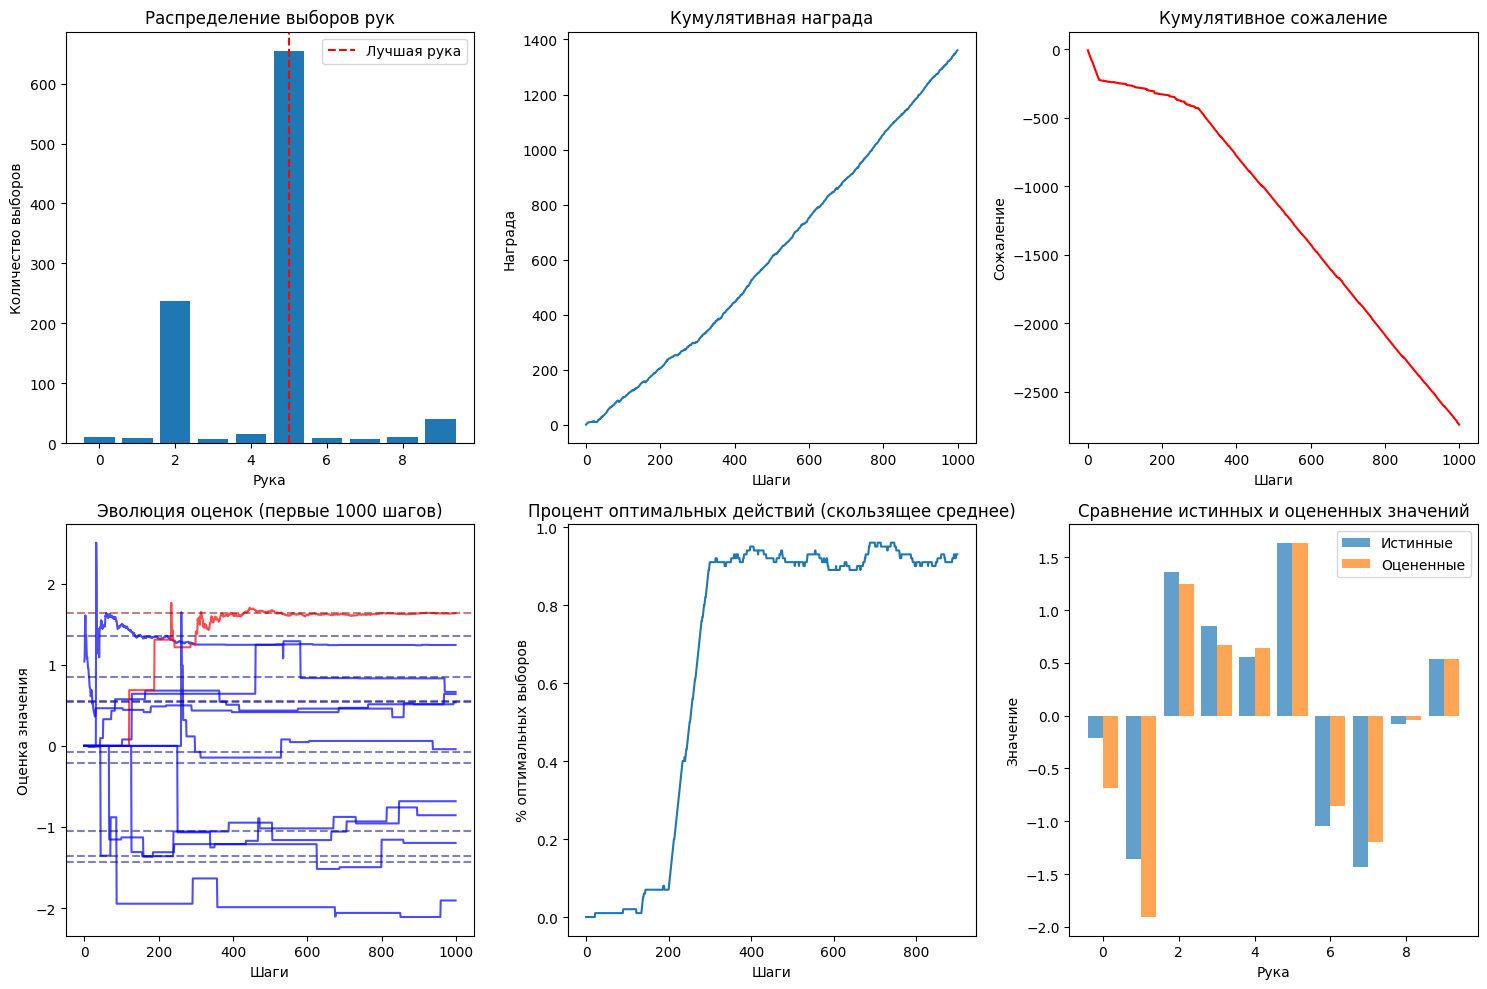

(<__main__.Agent at 0x123884ea6d0>, <__main__.Bandit at 0x1238849c990>)

In [208]:
run_experiment()